# Benchmark Round Trip time experiment (Switch)
This notebook will show you how to measure the round trip time between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

In [1]:
from dask.distributed import Client

client = Client("tcp://10.1.212.129:8786")
client

Client Scheduler: tcp://10.1.212.129:8786 Dashboard: http://10.1.212.129:8787/status,Cluster Workers: 2 Cores: 32 Memory: 232.35 GB


In [2]:
client_info = client.scheduler_info()['workers']
workers = []
for cli in client_info:
    workers.append(client_info[cli]['name'])

if len(workers) != 2:
    print("Configure your Dask cluster with two workers")

## Basic remote functions
In this part we are going to schedule a basic function to the workers to verify that we are able to pinpoint tasks to a particular worker, we are also going to grab the Alveo shell name.
You should visually check that your xclbin file is built for the Alveo shell available on the workers.

In [3]:
import platform, os

def verify_workers():
    node_name = platform.node()
    shell_version = os.popen("xbutil dump | grep dsa_name").read()
    #match = True
    #if 'xilinx_u280_xdma_201920_3' not in shell_version:
    #    match = False
    return node_name, shell_version[24:-2]

worker_0 = client.submit(verify_workers ,workers=workers[0], pure=False)
worker_1 = client.submit(verify_workers ,workers=workers[1], pure=False)

worker_check = [worker_0.result(),worker_1.result()]

for w in worker_check:
    print('Worker name: {} | shell version: {}'.format(w[0],w[1]))

Worker name: alveo3c | shell version: "xilinx_u280_xdma_201920_3"
Worker name: alveo4b | shell version: "xilinx_u280_xdma_201920_3"


## Source Dask device and utilities

In this section we will declare the Dask code that builds on top of the `pynq` framework. This piece of code allow us to:

* Download a `xclbin` file to a worker
* Peek and poke registers
* Allocate buffers
* Start kernels

All of these capabilities are available for both local and remote workers

In [4]:
from vnx_utils import *
import pynq
import ctypes
import tempfile
import numpy as np
import re
from pynq.pl_server.xrt_device import XrtStream

# Hold references to buffers to avoid them being collected
# Won't be visible in the process but is an easy way to
# let workers hold on to local references
buffers = []

# Functions that will be called in the context of dask
def _invalidate(bo, offset, size):
    buf = bytearray(size)
    pynq.Device.active_device.invalidate(bo, offset, 0, size)
    pynq.Device.active_device.buffer_read(bo, offset, buf)
    return bytes(buf)

def _flush(bo, offset, size, data):
    pynq.Device.active_device.buffer_write(bo, offset, bytearray(data))
    pynq.Device.active_device.flush(bo, offset, 0, size)
    
def _read_registers(address, length):
    return pynq.Device.active_device.read_registers(address, length)

def _write_registers(address, data):
    pynq.Device.active_device.write_registers(address, data)
    
def _download(bitstream_data):
    with tempfile.NamedTemporaryFile() as f:
        f.write(bitstream_data)
        f.flush()
        ol = pynq.Overlay(f.name)

def _alloc(size, memdesc):
    mem = pynq.Device.active_device.get_memory(memdesc)
    buf = mem.allocate((size,), 'u1')
    buffers.append(buf)
    return buf.bo, buf.device_address

class DaskMemory:
    """Memory object proxied over dask
    
    """
    def __init__(self, device, desc):
        self._desc = desc
        self._device = device
    
    def allocate(self, shape, dtype):
        from pynq.buffer import PynqBuffer
        buf = PynqBuffer(shape, dtype, device_address=0,
                         bo=0, device=self._device, coherent=False)
        bo, addr = self._device._call_dask(_alloc, buf.nbytes, self._desc)
        buf.bo = bo
        buf.device_address = addr
        return buf

class DaskDevice(pynq.Device):
    """PYNQ Proxy device for using PYNQ via dask
    
    """
    def __init__(self, client, worker):
        """The worker ID should be unique
        
        """
        super().__init__("dask-" + re.sub(r'[^\w]', '_', worker))
        self._dask_client = client
        self._worker = worker
        self.capabilities = {
            'REGISTER_RW': True,
            'CALLABLE': True
        }
        self._streams = {}
        
    def _call_dask(self, func, *args):
        future = self._dask_client.submit(func, *args, workers=self._worker, pure=False)
        return future.result()

    def invalidate(self, bo, offset, ptr, size):
        ctype = ctypes.c_uint8 * size
        target = ctype.from_address(ptr)
        target[:] = self._call_dask(_invalidate, bo, offset, size)
        
    def flush(self, bo, offset, ptr, size):
        ctype = ctypes.c_uint8 * size
        target = ctype.from_address(ptr)
        self._call_dask(_flush, bo, offset, size, bytes(target))
        
    def read_registers(self, address, length):
        return self._call_dask(_read_registers, address, length)
    
    def write_registers(self, address, data):
        self._call_dask(_write_registers, address, bytes(data))
        
    def get_bitfile_metadata(self, bitfile_name):
        return pynq.pl_server.xclbin_parser.XclBin(bitfile_name)
    
    def download(self, bitstream, parser=None):
        with open(bitstream.bitfile_name, 'rb') as f:
            bitstream_data = f.read()
        self._call_dask(_download, bitstream_data)
        super().post_download(bitstream, parser)
    
    def get_memory(self, desc):
        if desc['streaming']:
            if desc['idx'] not in self._streams:
                self._streams[desc['idx']] = XrtStream(self, desc)
            return self._streams[desc['idx']]
        else:
            return DaskMemory(self, desc)
    
    def get_memory_by_idx(self, idx):
        for m in self.mem_dict.values():
            if m['idx'] == idx:
                return self.get_memory(m)
        raise RuntimeError("Could not find memory")

## Download xclbin to workers
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [5]:
daskdev_w0 = DaskDevice(client, workers[0])
daskdev_w1 = DaskDevice(client, workers[1])

xclbin = '../benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=daskdev_w0)
ol_w1 = pynq.Overlay(xclbin, device=daskdev_w1)

/opt/tools/external/anaconda/envs/pynq-dask/lib/python3.7/site-packages/distributed/worker.py:3321: UserWarning: Large object of size 60.94 MB detected in task graph: 
  (b'xclbin2\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff ... ROR_DATA_END',)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between the two Alveo cards is established.

In [6]:
print("Link worker 0 {}; link worker 1 {}".format(ol_w0.cmac_0.linkStatus(),ol_w1.cmac_0.linkStatus()))

Link worker 0 {'cmac_link': True}; link worker 1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [7]:
ip_w0 , ip_w1 = '10.1.212.165' , '10.1.212.167'
if_status_w0 = ol_w0.networklayer_0.updateIPAddress(ip_w0, debug=True)
if_status_w1 = ol_w1.networklayer_0.updateIPAddress(ip_w1, debug=True)
print("Worker 0: {}\nWorker 1: {}".format(if_status_w0, if_status_w1))

Worker 0: {'HWaddr': '00:0a:35:02:9d:a5', 'inet addr': '10.1.212.165', 'gateway addr': '10.1.212.1', 'Mask': '255.255.255.0'}
Worker 1: {'HWaddr': '00:0a:35:02:9d:a7', 'inet addr': '10.1.212.167', 'gateway addr': '10.1.212.1', 'Mask': '255.255.255.0'}


### Configure remote Alveo card
1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [8]:
ol_w1.networklayer_0.sockets[0] = (ip_w0, 62177, 60512, True)
ol_w1.networklayer_0.populateSocketTable()

ol_w1.networklayer_0.arpDiscovery()

ol_w1.networklayer_0.readARPTable()

Position   1	MAC address 04:c5:a4:e3:fb:41	IP address 10.1.212.1
Position   4	MAC address 52:54:00:90:c2:04	IP address 10.1.212.4
Position   6	MAC address 52:54:00:90:c2:06	IP address 10.1.212.6
Position  11	MAC address 00:1e:67:34:65:b8	IP address 10.1.212.11
Position  12	MAC address 00:1e:67:34:63:b8	IP address 10.1.212.12
Position  13	MAC address 00:1e:67:34:64:00	IP address 10.1.212.13
Position  14	MAC address 00:1e:67:34:65:bc	IP address 10.1.212.14
Position  15	MAC address 00:1e:67:34:64:20	IP address 10.1.212.15
Position  16	MAC address 00:1e:67:34:64:08	IP address 10.1.212.16
Position  17	MAC address 00:1e:67:34:65:18	IP address 10.1.212.17
Position  18	MAC address 00:1e:67:34:65:28	IP address 10.1.212.18
Position  24	MAC address 90:e2:ba:04:74:e0	IP address 10.1.212.24
Position  25	MAC address 0c:42:a1:7c:c9:18	IP address 10.1.212.25
Position  33	MAC address 90:e2:ba:55:df:65	IP address 10.1.212.33
Position  41	MAC address 00:25:b5:00:00:1f	IP address 10.1.212.41
Position  42	

### Configure local Alveo

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [9]:
ol_w0.networklayer_0.sockets[2] = (ip_w1, 60512, 62177, True)
ol_w0.networklayer_0.populateSocketTable()

ol_w0.networklayer_0.arpDiscovery()

ol_w0.networklayer_0.readARPTable()

Position   1	MAC address 04:c5:a4:e3:fb:41	IP address 10.1.212.1
Position   4	MAC address 52:54:00:90:c2:04	IP address 10.1.212.4
Position   6	MAC address 52:54:00:90:c2:06	IP address 10.1.212.6
Position  11	MAC address 00:1e:67:34:65:b8	IP address 10.1.212.11
Position  12	MAC address 00:1e:67:34:63:b8	IP address 10.1.212.12
Position  13	MAC address 00:1e:67:34:64:00	IP address 10.1.212.13
Position  14	MAC address 00:1e:67:34:65:bc	IP address 10.1.212.14
Position  15	MAC address 00:1e:67:34:64:20	IP address 10.1.212.15
Position  16	MAC address 00:1e:67:34:64:08	IP address 10.1.212.16
Position  17	MAC address 00:1e:67:34:65:18	IP address 10.1.212.17
Position  18	MAC address 00:1e:67:34:65:28	IP address 10.1.212.18
Position  24	MAC address 90:e2:ba:04:74:e0	IP address 10.1.212.24
Position  25	MAC address 0c:42:a1:7c:c9:18	IP address 10.1.212.25
Position  33	MAC address 90:e2:ba:55:df:65	IP address 10.1.212.33
Position  41	MAC address 00:25:b5:00:00:1f	IP address 10.1.212.41
Position  42	

## Configure application

* Configure remote benchmark `traffic_generator_0_0` application in `LOOPBACK` mode

In [10]:
ol_w1_tg = ol_w1.traffic_generator_0_0
ol_w1_tg.register_map.mode = benchmark_mode.index('LOOPBACK')
ol_w1_tg.register_map.dest_id = 0 # Use connection in position 0 to reflect
ol_w1_tg.register_map.CTRL.AP_START = 1

### Configure local benchmark application
This part configures the collector, in particular
* Allocate buffers
* Start collector

In [11]:
send_packets   = 2 ** 20
shape          = (send_packets,1)
rtt_cycles     = pynq.allocate(shape, dtype=np.uint32, target=ol_w0.HBM0)
pkt            = pynq.allocate(1,     dtype=np.uint32, target=ol_w0.HBM0)

collector_h = ol_w0.collector_0_2.start(rtt_cycles,pkt)


**This part configures the traffic generator** `traffic_generator_0_2`

In [12]:
send_pkts = send_packets
ol_w0_tg = ol_w0.traffic_generator_0_2
ol_w0_tg.register_map.debug_reset = 1
ol_w0.networklayer_0.register_map.debug_reset_counters = 1
ol_w0_tg.register_map.mode = benchmark_mode.index('LATENCY')
ol_w0_tg.register_map.number_packets = send_pkts
ol_w0_tg.register_map.time_between_packets = 50
ol_w0_tg.register_map.number_beats = 1
ol_w0_tg.register_map.dest_id = 2
ol_w0_tg.register_map.CTRL.AP_START = 1

## Read latency result
* Call the dask method to synchronize the Alveo buffer with the dask buffer

Note that this buffer contains the round trip time in clock cycles

In [13]:
rtt_cycles.invalidate()
rtt_cycles

PynqBuffer([[809],
            [809],
            [807],
            ...,
            [806],
            [804],
            [803]], dtype=uint32)

## Compute some statistics on the results
1. Convert the rtt from cycles to microseconds, for this particular implementation the clock frequency is 292 MHz. Check current kernel frequency `xbutil | dump`

In [14]:
freq = 292
rtt_usec = np.array(shape, dtype=np.float)
rtt_usec= rtt_cycles / freq  # convert to microseconds

2. Use `scipy` to compute statistical values
    * Mean
    * Standard deviation
    * Mode

In [15]:
from scipy import stats
mean, std_dev, mode = np.mean(rtt_usec), np.std(rtt_usec), stats.mode(rtt_usec)
print("Round trip time at application level using {:,} packets".format(len(rtt_usec)))
print("\tmean    = {:.3f} us\n\tstd_dev = {:.6f} us".format(mean,std_dev))
print("\tmode    = {:.3f} us, which appears {:,} times".format(mode[0][0][0],mode[1][0][0]))
print("\tmax     = {:.3f} us".format(np.max(rtt_usec)))
print("\tmin     = {:.3f} us".format(np.min(rtt_usec)))

Round trip time at application level using 1,048,576 packets
	mean    = 2.762 us
	std_dev = 0.005586 us
	mode    = 2.760 us, which appears 245,232 times
	max     = 2.825 us
	min     = 2.743 us


## Plot Box and whisker graph

{'whiskers': [<matplotlib.lines.Line2D at 0x7f320065b5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f320065b9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3200609190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32006091d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32005fb850>],
 'means': []}

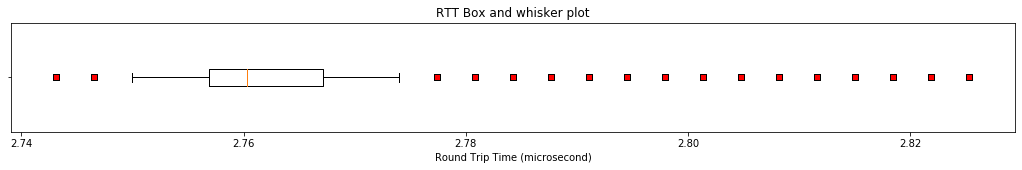

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

red_square = dict(markerfacecolor='r', marker='s')
fig, ax = plt.subplots()
ax.set_title('RTT Box and whisker plot')
ax.set_xlabel('Round Trip Time (microsecond)')
ax.set_yticklabels([''])
fig.set_size_inches(18, 2)
ax.boxplot(rtt_usec, vert=False, flierprops=red_square)

## Release Alveo cards
* To release the alveo cards the pynq overlay is freed
* Delete dask pynq-dask buffers

In [16]:
pynq.Overlay.free(ol_w0)
pynq.Overlay.free(ol_w1)
del rtt_cycles
del pkt

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.